# Kish Basin Statistics

In [1]:
import glob
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
import xarray as xr
from geocube.api.core import make_geocube

In [2]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset

    Parameters
    ----------
    dat_path : path to the .dat files
    dat_crs : CRS
    """

    gdf = {}
    # for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
    for dat_file in [
        x for x in glob.glob(
            os.path.join(dat_path, "*.dat")
        ) if "Zone" not in x
    ]:

        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[-1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[-1][:-4]]["data"] = (
            os.path.split(dat_file)[-1][:-4]
        )

    # find data resolution
    gdf_xr = gdf[list(gdf.keys())[0]].set_index(["X", "Y"]).to_xarray()
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["geometry"] = gpd.points_from_xy(gdf.X, gdf.Y, crs=dat_crs)
    gdf = gpd.GeoDataFrame(gdf)
    gdf.drop(columns=["X", "Y"], inplace=True)

    # convert to Xarray dataset
    xds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # split variables and halite members
    xds_ = {}
    for d in xds["data"].values:
        halite_member = d.split(" ")[0]
        if halite_member == "Presall":
            halite_member = "Preesall"
        unit = d.split(" ")[-1]
        zvar = d.split("Halite ")[-1].split(" XYZ")[0]
        xds_[d] = xds.sel(data=d).assign_coords(
            halite=halite_member
        ).expand_dims(dim="halite").drop_vars("data")
        xds_[d] = xds_[d].rename({"Z": zvar.replace(" ", "")})
        xds_[d][zvar.replace(" ", "")] = (
            xds_[d][zvar.replace(" ", "")].assign_attrs(
                units=unit, long_name=zvar
            )
        )

    xds = xr.combine_by_coords(xds_.values(), combine_attrs="override")

    # # keep only points corresponding to zones of interest in the dataframe
    # zones = gdf.loc[gdf["data"].str.contains("Zone")]

    # # create zones of interest polygon
    # zones = gpd.GeoDataFrame(geometry=zones.buffer(100).envelope).dissolve()

    # create extent polygon
    dat_extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    dat_extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (dat_extent[" X"][0], dat_extent[" Y"][0]),
            (dat_extent[" X"][1], dat_extent[" Y"][1]),
            (dat_extent[" X"][2], dat_extent[" Y"][2]),
            (dat_extent[" X"][3], dat_extent[" Y"][3])
        ]),
        crs=dat_crs
    )

    return xds, dat_extent,  # zones

In [4]:
ds, extent = read_dat_file(DATA_DIR, CRS)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [6]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        fig = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_)
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(fig.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        fig.set_titles("{value}", weight="semibold")
        plt.show()

In [7]:
ds

<xarray.Dataset>
Dimensions:      (halite: 4, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
    spatial_ref  int64 0
  * halite       (halite) <U8 'Flyde' 'Mythop' 'Preesall' 'Rossall'
Data variables:
    BaseDepth    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Thickness    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopDepth     (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopTWT       (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [8]:
ds.rio.crs

CRS.from_epsg(23029)

In [9]:
ds.rio.resolution()

(200.0, -200.0)

In [10]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

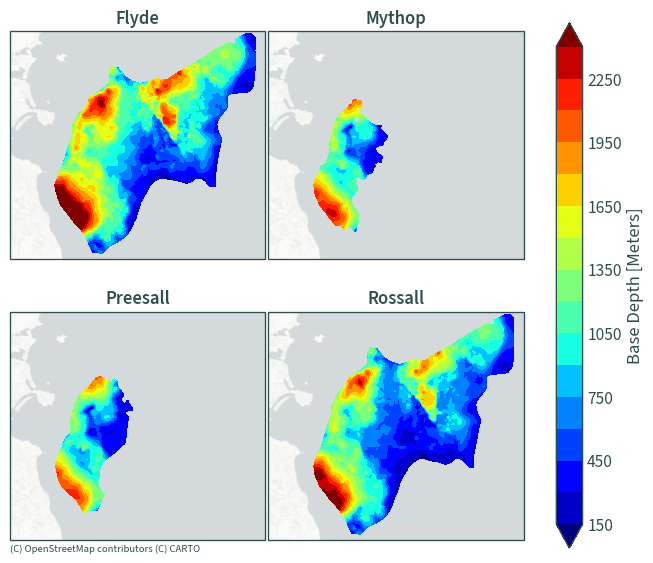

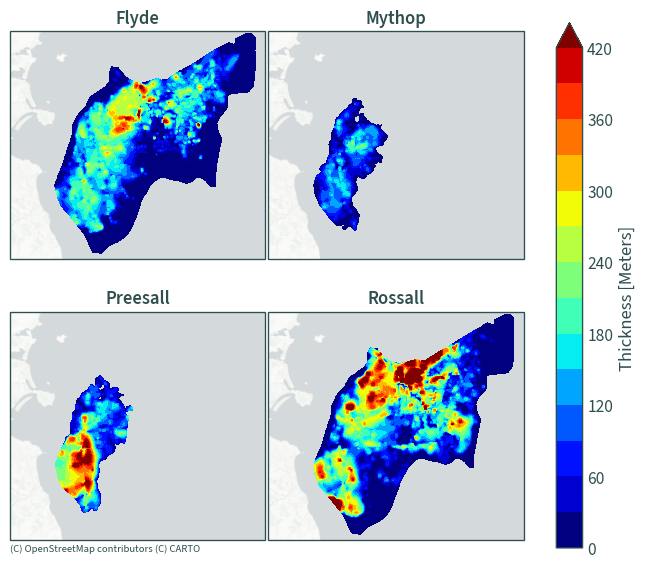

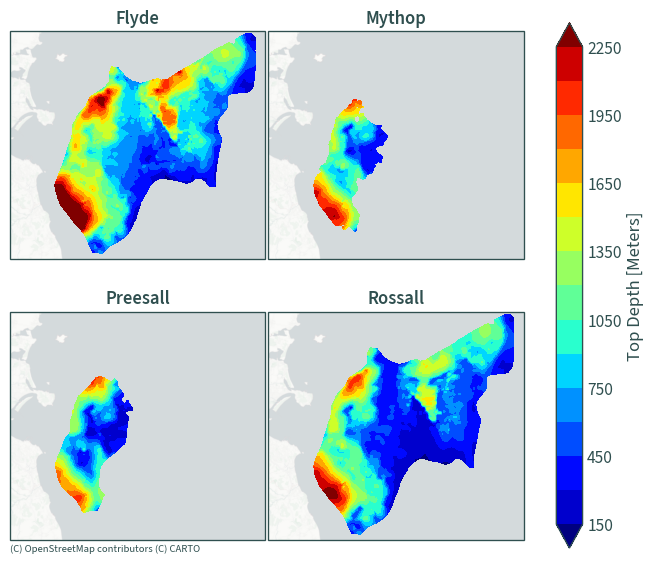

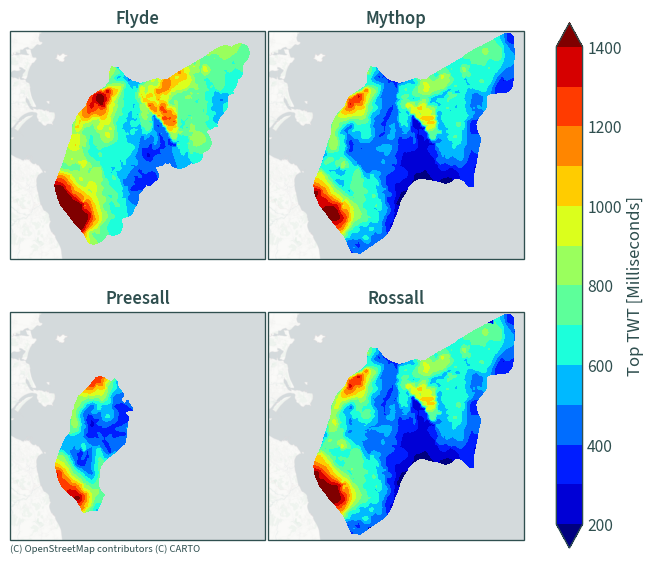

In [11]:
plot_facet_maps(ds, extent, CRS)

## Stats

In [12]:
df = ds.to_dataframe()[list(ds.data_vars)]

In [13]:
df.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,63868.000000,63456.000000,63868.000000,80386.000000
mean,1011.301702,112.835875,899.392295,653.242487
std,536.478279,113.380006,507.401263,259.464713
min,120.324500,0.000000,120.324500,136.616000
25%,574.370900,4.344600,476.546675,468.859575
50%,952.930250,90.634850,818.911100,631.917300
75%,1334.956375,178.472675,1207.349725,776.623200
max,3512.489700,1111.067000,3273.030800,1911.048300


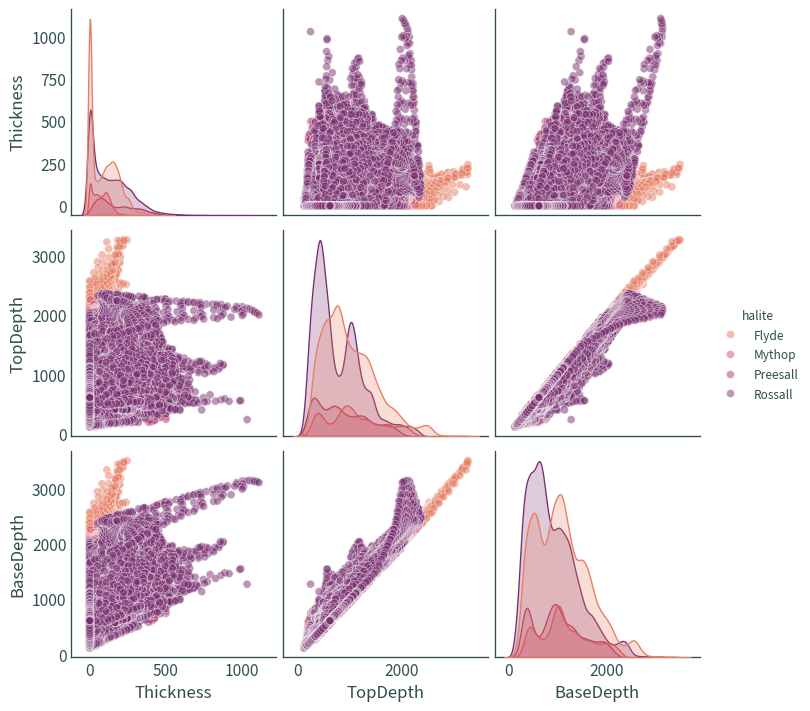

In [14]:
sns.pairplot(
    df.reset_index(), palette="flare", hue="halite", plot_kws={"alpha": .5},
    vars=["Thickness", "TopDepth", "BaseDepth"]
)
plt.show()

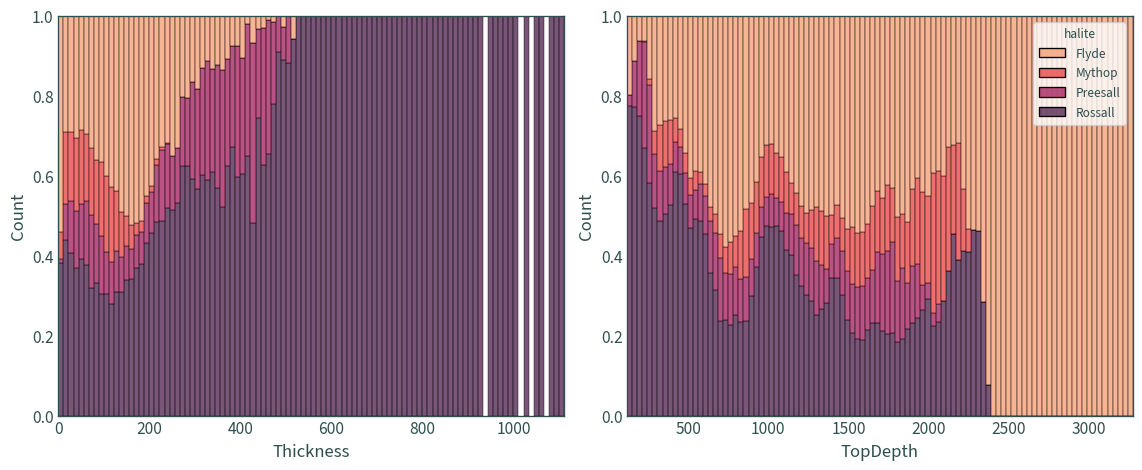

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    df.reset_index(), x="Thickness", hue="halite", ax=axes[0],
    palette="rocket_r", multiple="fill", bins=100, legend=False
)
sns.histplot(
    df.reset_index(), x="TopDepth", hue="halite", ax=axes[1],
    palette="rocket_r", multiple="fill", bins=100
)
plt.tight_layout()
plt.show()

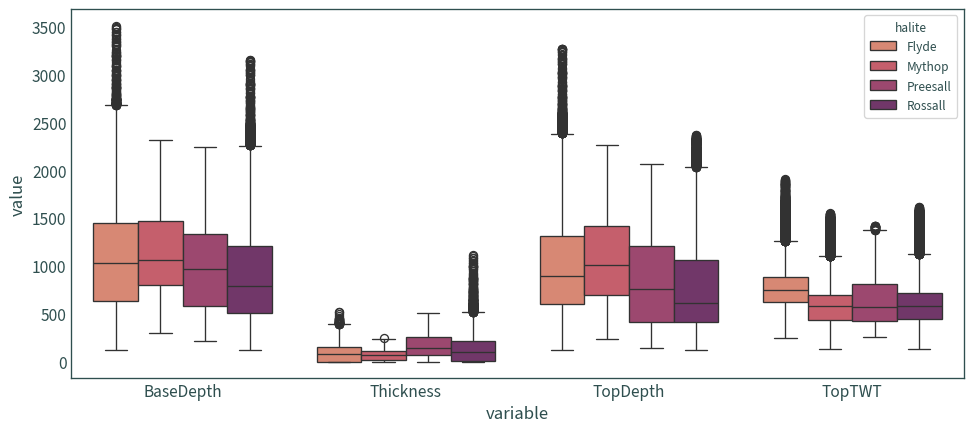

In [16]:
plt.subplots(figsize=(12, 5))
sns.boxplot(
    pd.melt(df.reset_index().drop(columns=["x", "y"]), id_vars=["halite"]),
    x="variable", y="value", hue="halite", palette="flare"
)
plt.show()

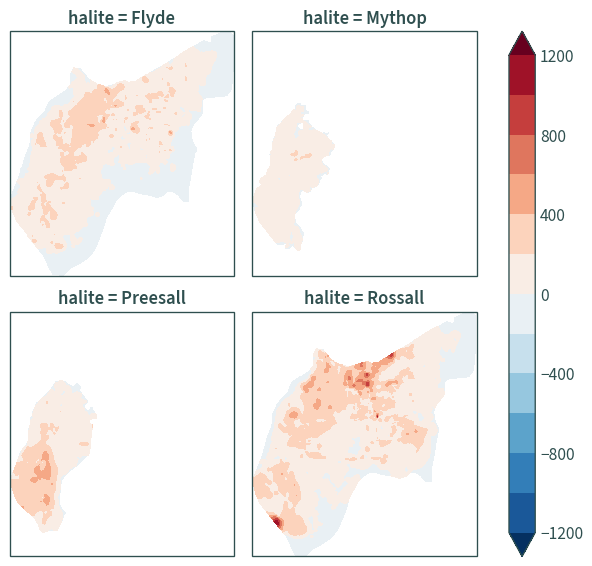

In [17]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot.contourf(
    col="halite", col_wrap=2, extend="both", levels=15,
    subplot_kws={"projection": ccrs.epsg(CRS)}
)
plt.show()

In [18]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [19]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679

## Zones of interest

In [24]:
def zones_of_interest(
    dat_xr, dat_extent, dat_crs, min_thickness, min_depth, max_depth,
    plot_map=True
):
    """
    Generate a (multi)polygon of the zones of interest by applying thickness
    and depth constraints.

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    min_thickness : minimum halite thickness [m]
    min_depth : minimum halite top depth [m]
    max_depth : maximum halite top depth [m]

    Returns
    -------
    - A (multi)polygon geodataframe of the zones of interest
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    zds = dat_xr.where(
        (
            (dat_xr.Thickness >= min_thickness)
            & (dat_xr.TopDepth >= min_depth)
            & (dat_xr.TopDepth <= max_depth)
        ),
        drop=True
    )

    # zones of interest polygon
    zdf = zds.max(
        dim="halite"
    )["Thickness"].to_dataframe().dropna().reset_index()
    zdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(
            gpd.points_from_xy(zdf.x, zdf.y)
        ).buffer(100).envelope,
        crs=dat_crs
    ).dissolve()

    if plot_map:
        ax = plt.axes(projection=ccrs.epsg(dat_crs))
        zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
        plt.xlim(xmin_, xmax_)
        plt.ylim(ymin_, ymax_)
        cx.add_basemap(
            ax, source=cx.providers.CartoDB.PositronNoLabels, crs=dat_crs
        )
        plt.title("Zones of interest")
        plt.tight_layout()
        plt.show()

    return zdf, zds

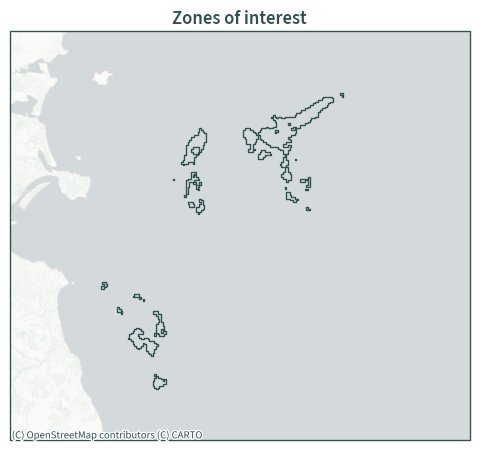

In [25]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones, zds = zones_of_interest(ds, extent, CRS, 300, 1000, 1500)

## Zones of interest stats

In [27]:
zdf = zds.to_dataframe()[list(ds.data_vars)]

In [28]:
zdf.describe()

,BaseDepth,Thickness,TopDepth,TopTWT
count,1083.000000,1083.000000,1083.000000,1083.000000
mean,1595.485859,385.637362,1209.848497,805.993834
std,163.222260,90.468818,137.930903,96.597518
min,1304.445200,300.198500,1000.017100,625.339500
25%,1456.160350,324.322150,1089.126400,724.868350
50%,1584.044200,356.411000,1195.798300,795.055300
75%,1718.836300,416.067600,1316.857150,878.153000
max,2045.991200,877.043200,1499.461100,1090.956900


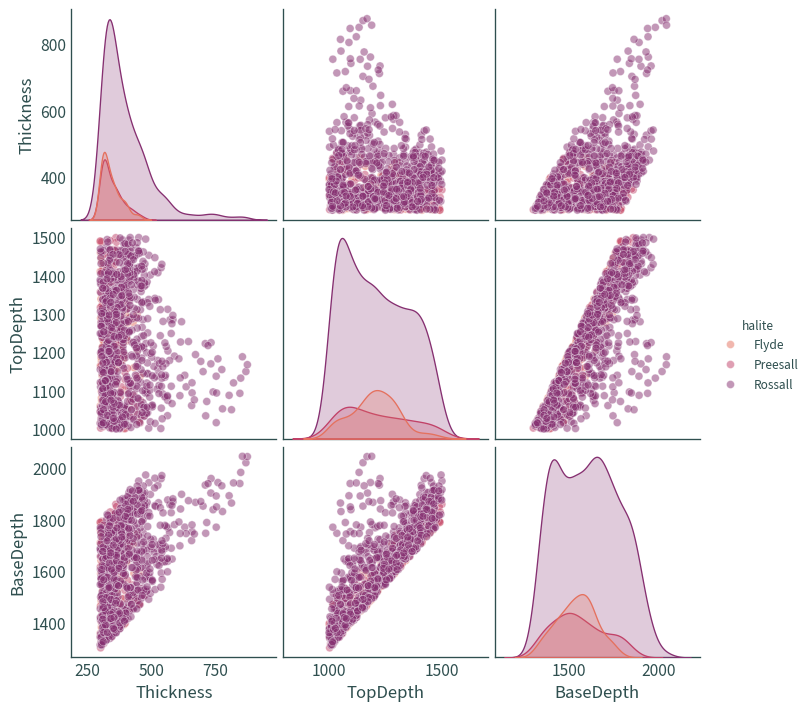

In [29]:
sns.pairplot(
    zdf.reset_index(), palette="flare", hue="halite", plot_kws={"alpha": .5},
    vars=["Thickness", "TopDepth", "BaseDepth"]
)
plt.show()

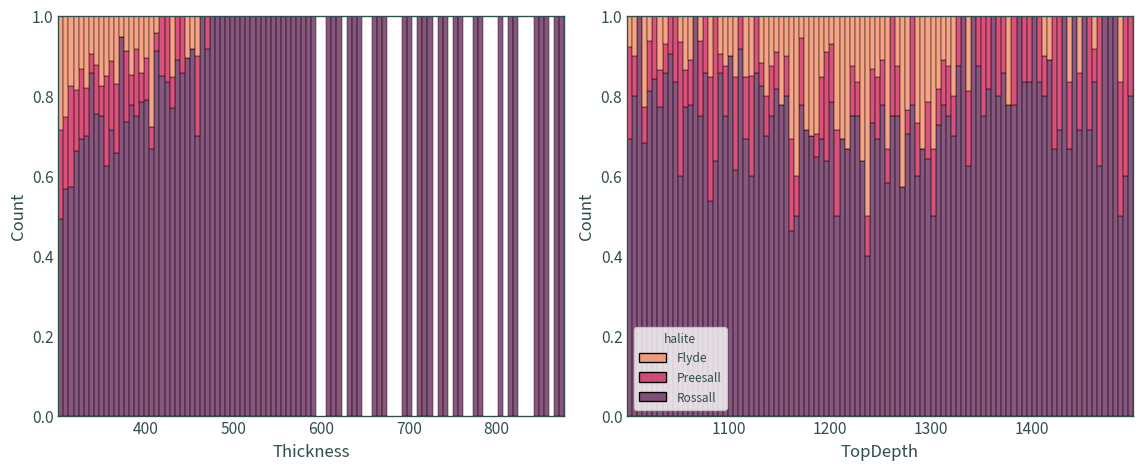

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    zdf.reset_index(), x="Thickness", hue="halite", ax=axes[0],
    palette="rocket_r", multiple="fill", bins=100, legend=False
)
sns.histplot(
    zdf.reset_index(), x="TopDepth", hue="halite", ax=axes[1],
    palette="rocket_r", multiple="fill", bins=100
)
plt.tight_layout()
plt.show()

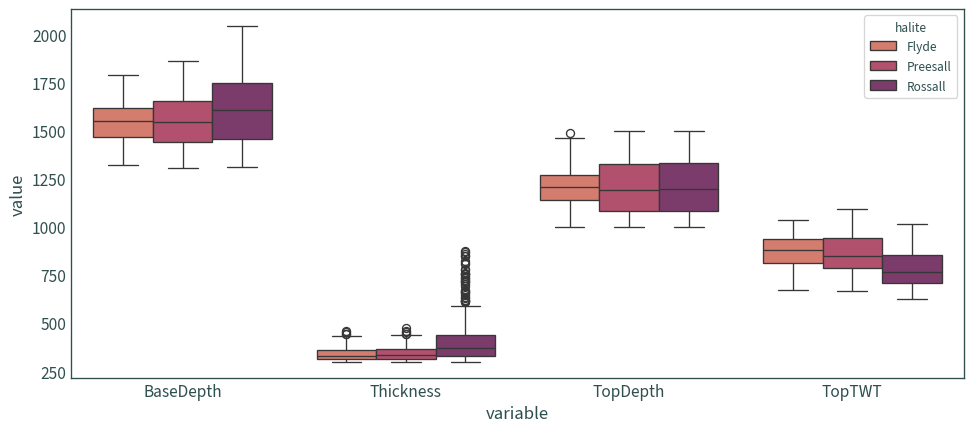

In [31]:
plt.subplots(figsize=(12, 5))
sns.boxplot(
    pd.melt(zdf.reset_index().drop(columns=["x", "y"]), id_vars=["halite"]),
    x="variable", y="value", hue="halite", palette="flare"
)
plt.show()

## Sensitivity analysis

Sensitivity of maximum halite area (i.e. zones of interest) available for
cavern construction (without constraints) to depth and thickness

In [33]:
# sensitivity to minimum thickness
min_thickness = [200 + 5 * n for n in range(41)]
max_area = []

for t in min_thickness:
    max_area.append(
        zones_of_interest(
            ds, extent, CRS, t, 1000, 1500, plot_map=False
        )[0].area[0]
    )

sdf = pd.DataFrame({"max_area": max_area, "min_thickness": min_thickness})

# percentage change
sdf["diff_area"] = (sdf["max_area"] - zones.area[0]) / zones.area[0] * 100

In [34]:
sdf.describe()

,max_area,min_thickness,diff_area
count,4.100000e+01,41.000000,41.000000
mean,5.609073e+07,300.000000,29.599657
std,3.806630e+07,59.895743,87.953554
min,1.312000e+07,200.000000,-69.685767
25%,2.364000e+07,250.000000,-45.378928
50%,4.328000e+07,300.000000,0.000000
75%,8.456000e+07,350.000000,95.378928
max,1.395600e+08,400.000000,222.458410


In [35]:
# sensitivity to minimum depth
min_depth = [500 + 12.5 * n for n in range(49)]
max_area = []

for d in min_depth:
    max_area.append(
        zones_of_interest(
            ds, extent, CRS, 300, d, 1500, plot_map=False
        )[0].area[0]
    )

sdf1 = pd.DataFrame({"max_area": max_area, "min_depth": min_depth})

# percentage change
sdf1["diff_area"] = (sdf1["max_area"] - zones.area[0]) / zones.area[0] * 100

In [36]:
sdf1.describe()

,max_area,min_depth,diff_area
count,4.900000e+01,49.000000,49.000000
mean,6.636082e+07,800.000000,53.329058
std,2.250140e+07,178.608627,51.990297
min,3.120000e+07,500.000000,-27.911275
25%,4.896000e+07,650.000000,13.123845
50%,6.216000e+07,800.000000,43.622921
75%,8.524000e+07,950.000000,96.950092
max,1.088800e+08,1100.000000,151.571165


In [37]:
# sensitivity to maximum depth
max_depth = [1400 + 12.5 * n for n in range(57)]
max_area = []

for d in max_depth:
    max_area.append(
        zones_of_interest(
            ds, extent, CRS, 300, 1000, d, plot_map=False
        )[0].area[0]
    )

sdf2 = pd.DataFrame({"max_area": max_area, "max_depth": max_depth})

# percentage change
sdf2["diff_area"] = (sdf2["max_area"] - zones.area[0]) / zones.area[0] * 100

In [38]:
sdf2.describe()

,max_area,max_depth,diff_area
count,5.700000e+01,57.000000,57.000000
mean,5.028561e+07,1750.000000,16.186724
std,6.475534e+06,207.477408,14.961954
min,3.796000e+07,1400.000000,-12.292052
25%,4.528000e+07,1575.000000,4.621072
50%,4.964000e+07,1750.000000,14.695009
75%,5.624000e+07,1925.000000,29.944547
max,6.064000e+07,2100.000000,40.110906


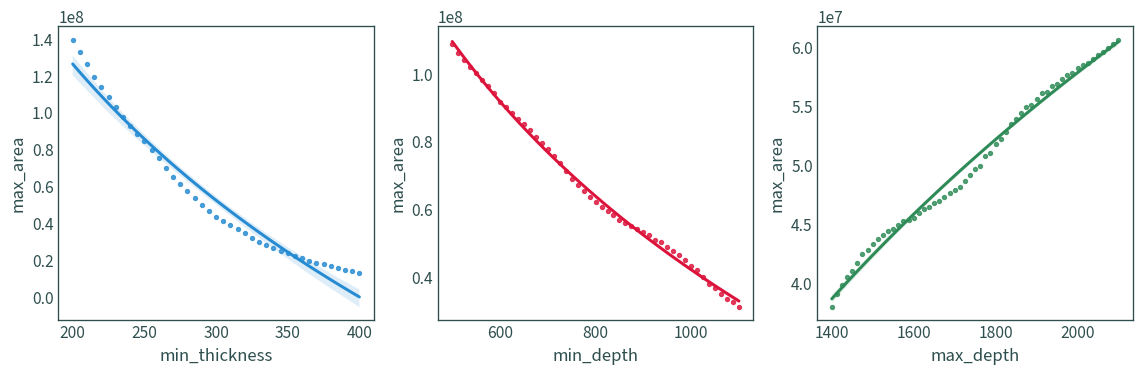

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.regplot(
    sdf, x="min_thickness", y="max_area", logx=True, ax=axes[0], marker="."
)
sns.regplot(
    sdf1, x="min_depth", y="max_area", logx=True, ax=axes[1], color="crimson",
    marker="."
)
sns.regplot(
    sdf2, x="max_depth", y="max_area", logx=True, ax=axes[2], color="seagreen",
    marker="."
)
plt.tight_layout()
plt.show()

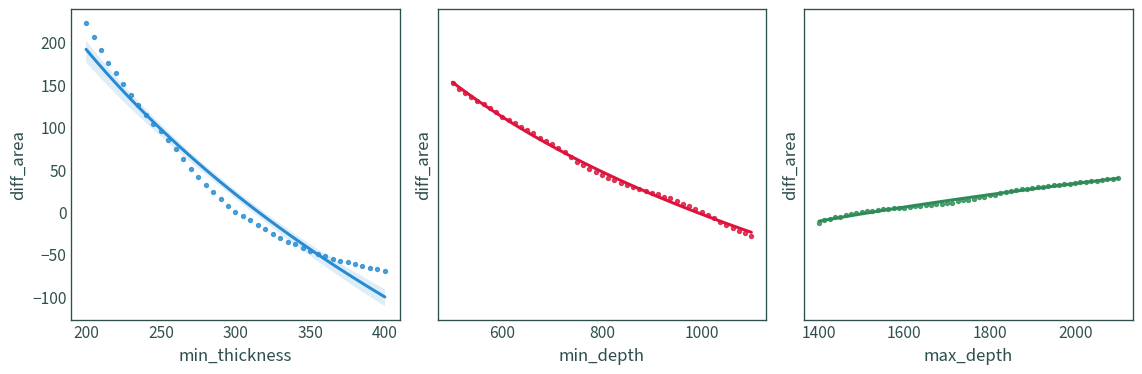

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
sns.regplot(
    sdf, x="min_thickness", y="diff_area", logx=True, ax=axes[0], marker="."
)
sns.regplot(
    sdf1, x="min_depth", y="diff_area", logx=True, ax=axes[1], color="crimson",
    marker="."
)
sns.regplot(
    sdf2, x="max_depth", y="diff_area", logx=True, ax=axes[2],
    color="seagreen", marker="."
)
plt.tight_layout()
plt.show()